In [ ]:
import torch
words = open('names.txt', 'r').read().splitlines()

In [85]:
N = torch.ones((27,27), dtype=torch.int32)

In [86]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

In [87]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [88]:
itos = {i:s for s,i in stoi.items()}

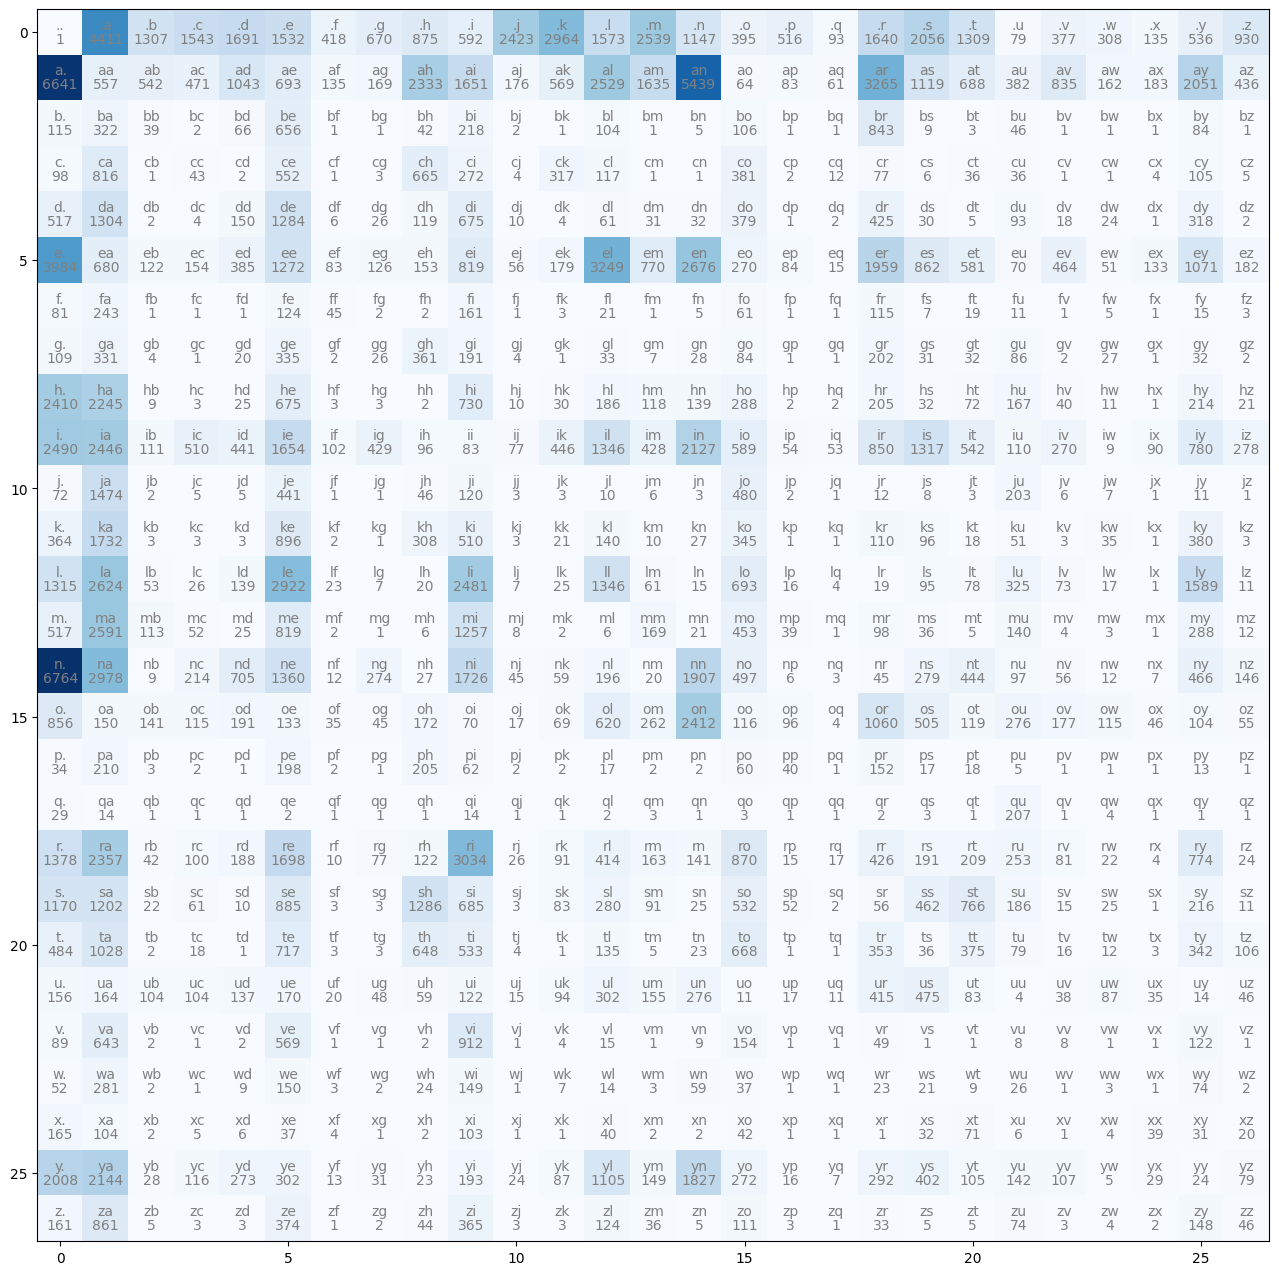

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='gray')

In [90]:
p = N[0].float()
p /= p.sum()

In [91]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]


'j'

In [92]:
P = N.float()
P /= P.sum(dim=1, keepdim=True)

In [93]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    out = []
    ix = 0
    while True:
        # p = N[ix].float()
        # p /= p.sum()
        # p = torch.ones(27) / 27.
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


In [100]:
log_liklihood = 0.0
n=0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_liklihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.3f} {logprob:.3f}')
print(f'{log_liklihood=:.3f}')
nll = -log_liklihood / n
print(f'{nll=:.3f}')

log_liklihood=-33.568
nll=3.730


In [102]:
# create the training set of bigrams

xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs, ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [116]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()
# plt.imshow(xenc, cmap='Blues')

W = torch.randn((27, 27), generator=g)
logits = xenc @ W # log-counts
counts = logits.exp() # equiv to N
probs = counts / counts.sum(1, keepdim=True)

In [ ]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item()
    y = ys[i].item()
    print('--------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x}, {y})')
    print('input to the neural net: ',  probs[i])
    print('output probabilities: ', probs[i])
    print('label (actual next character): %.3f' % y)
    p = probs[i,y]
    print('probability assigned by the net to the correct char: %.3f' % p.item())
    logp = torch.log(p)
    print('log liklihood: %.3f' % logp.item())
    nll = -logp
    print('negative log liklihood: %.3f' % nll.item())
    nlls[i] = nll

print('=========')
print('average negative log liklihood, i.e. loss: %.3f' % nlls.mean().item())

In [172]:
# forward pass

xenc = F.one_hot(xs, num_classes=27).float()
# plt.imshow(xenc, cmap='Blues')
logits = xenc @ W # log-counts
counts = logits.exp() # equiv to N
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(5), ys].log().mean()

In [173]:
print(loss.item())

3.669245958328247


In [174]:
# backward pass
W.grad = None  # clear gradients
loss.backward()  # compute gradients

In [175]:
# update weights
W.data += -0.1 * W.grad  # update weights

In [177]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f'examples {num=}')

# initialize the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

examples num=228146


In [180]:
# gradient descent

for epoch in range(1000):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W # log-counts
    counts = logits.exp() # equiv to N
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean()

    # backward pass
    W.grad = None  # clear gradients
    loss.backward()  # compute gradients

    # update weights inverse correlated to epoch
    W.data += -0.1 * W.grad  # update weights

    if epoch % 100 == 0:
        print(f'{epoch=}, {loss.item():.3f}')

epoch=0, 3.153
epoch=100, 3.123
epoch=200, 3.095
epoch=300, 3.070
epoch=400, 3.046
epoch=500, 3.024
epoch=600, 3.003
epoch=700, 2.984
epoch=800, 2.966
epoch=900, 2.949
